In [4]:
!pip install qiskit qiskit_aer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 58.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 86.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 70.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 2.2 MB/s eta 0:00:00


In [5]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit_aer.noise import NoiseModel, depolarizing_error
import numpy as np
import matplotlib.pyplot as plt



In [7]:

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt

def bv_oracle_with_b(qc, inputs, ancilla, s, b):
    """Implements oracle for f(x) = s · x ⊕ b."""
    for i, bit in enumerate(s):
        if bit == '1':
            qc.cx(inputs[i], ancilla)

    if b == '1':
        qc.x(ancilla)

def bernstein_vazirani_circuit_with_b(s, b):
    n = len(s)
    qreg = QuantumRegister(n + 1, 'q')
    creg = ClassicalRegister(n, 'c')
    qc = QuantumCircuit(qreg, creg)
    inputs = list(range(n))
    ancilla = n

    qc.x(ancilla)
    qc.h(qreg)
    bv_oracle_with_b(qc, inputs, ancilla, s, b)
    for q in inputs:
        qc.h(q)
    qc.measure(inputs, creg)
    return qc

def run_bv_with_b(qc, shots=1024):
    sim = AerSimulator()
    tqc = transpile(qc, sim)
    job = sim.run(tqc, shots=shots)
    result = job.result()
    counts = result.get_counts()
    return counts

# Test with b = 0 and b = 1
s = '1011'

for b in ['0', '1']:
    print(f'\nTesting: s = {s}, b = {b}')
    qc = bernstein_vazirani_circuit_with_b(s, b)
    print(qc.draw())

    counts = run_bv_with_b(qc)
    print('Counts:', counts)
    plot_histogram(counts, title=f's={s}, b={b}')
    plt.show()

    most = max(counts, key=counts.get)
    measured_reversed = most[::-1]
    print(f'Measured (reversed): {measured_reversed}')
    print(f'Note: b={b} does not affect the measured result for s')



Testing: s = 1011, b = 0
     ┌───┐          ┌───┐          ┌─┐           
q_0: ┤ H ├───────■──┤ H ├──────────┤M├───────────
     ├───┤┌───┐  │  └┬─┬┘          └╥┘           
q_1: ┤ H ├┤ H ├──┼───┤M├────────────╫────────────
     ├───┤└───┘  │   └╥┘      ┌───┐ ║      ┌─┐   
q_2: ┤ H ├───────┼────╫────■──┤ H ├─╫──────┤M├───
     ├───┤       │    ║    │  └───┘ ║ ┌───┐└╥┘┌─┐
q_3: ┤ H ├───────┼────╫────┼────■───╫─┤ H ├─╫─┤M├
     ├───┤┌───┐┌─┴─┐  ║  ┌─┴─┐┌─┴─┐ ║ └───┘ ║ └╥┘
q_4: ┤ X ├┤ H ├┤ X ├──╫──┤ X ├┤ X ├─╫───────╫──╫─
     └───┘└───┘└───┘  ║  └───┘└───┘ ║       ║  ║ 
c: 4/═════════════════╩═════════════╩═══════╩══╩═
                      1             0       2  3 
Counts: {'1101': 1024}
Measured (reversed): 1011
Note: b=0 does not affect the measured result for s

Testing: s = 1011, b = 1
     ┌───┐          ┌───┐          ┌─┐           
q_0: ┤ H ├───────■──┤ H ├──────────┤M├───────────
     ├───┤┌───┐  │  └┬─┬┘          └╥┘           
q_1: ┤ H ├┤ H ├──┼───┤M├────────────╫──────────

In [8]:

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt

def bv_oracle(qc, inputs, ancilla, s):
    for i, bit in enumerate(s):
        if bit == '1':
            qc.cx(inputs[i], ancilla)

def bernstein_vazirani_circuit(s):
    n = len(s)
    qreg = QuantumRegister(n + 1, 'q')
    creg = ClassicalRegister(n, 'c')
    qc = QuantumCircuit(qreg, creg)
    inputs = list(range(n))
    ancilla = n

    qc.x(ancilla)
    qc.h(qreg)
    bv_oracle(qc, inputs, ancilla, s)
    for q in inputs:
        qc.h(q)
    qc.measure(inputs, creg)
    return qc

def create_noise_model(error_rate):
    noise_model = NoiseModel()
    error_1q = depolarizing_error(error_rate, 1)
    noise_model.add_all_qubit_quantum_error(error_1q, ['h', 'x'])
    error_2q = depolarizing_error(error_rate * 2, 2)
    noise_model.add_all_qubit_quantum_error(error_2q, ['cx'])
    return noise_model

def run_bv_with_noise(qc, noise_model=None, shots=1024):
    sim = AerSimulator(noise_model=noise_model)
    tqc = transpile(qc, sim)
    job = sim.run(tqc, shots=shots)
    result = job.result()
    counts = result.get_counts()
    return counts

# Test with different noise levels
s = '1011'
error_rates = [0.0, 0.01, 0.05, 0.1]
shots = 2048

print(f'Secret string s = {s}\n')

for error_rate in error_rates:
    print(f'Error Rate: {error_rate:.2%}')
    qc = bernstein_vazirani_circuit(s)

    noise_model = None if error_rate == 0.0 else create_noise_model(error_rate)
    counts = run_bv_with_noise(qc, noise_model, shots)

    most = max(counts, key=counts.get)
    measured_reversed = most[::-1]
    success_rate = counts[most] / shots * 100

    print(f'Measured: {measured_reversed}, Success Rate: {success_rate:.1f}%')
    print(f'Top results: {dict(sorted(counts.items(), key=lambda x: x[1], reverse=True)[:3])}')

    plot_histogram(counts, title=f'Error Rate: {error_rate:.2%}')
    plt.show()
    print()

Secret string s = 1011

Error Rate: 0.00%
Measured: 1011, Success Rate: 100.0%
Top results: {'1101': 2048}

Error Rate: 1.00%
Measured: 1011, Success Rate: 93.1%
Top results: {'1101': 1907, '0000': 38, '0101': 35}

Error Rate: 5.00%
Measured: 1011, Success Rate: 67.0%
Top results: {'1101': 1372, '0101': 175, '1001': 129}

Error Rate: 10.00%
Measured: 1011, Success Rate: 45.3%
Top results: {'1101': 927, '0101': 280, '1001': 202}



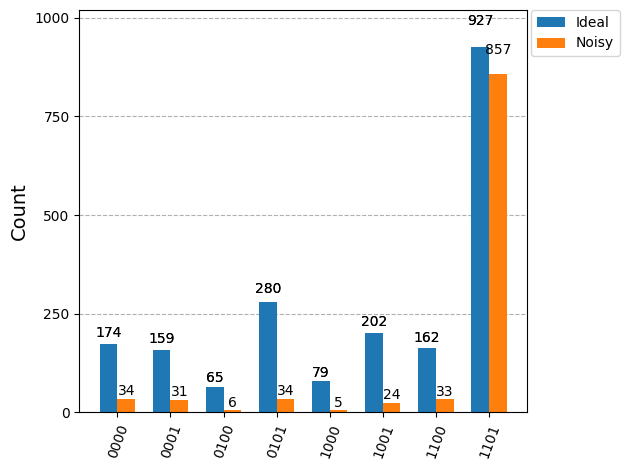

In [9]:
from qiskit_aer.noise import NoiseModel, depolarizing_error
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit import transpile

# Create a new noise model
noise_model = NoiseModel()

# Define depolarizing errors
error_1 = depolarizing_error(0.02, 1)  # 2% single-qubit noise
error_2 = depolarizing_error(0.05, 2)  # 5% two-qubit noise (for cx gate)

# Add them to the model
noise_model.add_all_qubit_quantum_error(error_1, ['h', 'x'])
noise_model.add_all_qubit_quantum_error(error_2, ['cx'])

# Create noisy simulator
noisy_sim = AerSimulator(noise_model=noise_model)

# Transpile and run the circuit on the noisy simulator
qc_transpiled = transpile(qc, noisy_sim)
noisy_result = noisy_sim.run(qc_transpiled).result()

# Get counts
noisy_counts = noisy_result.get_counts()

# Compare ideal vs noisy results
plot_histogram([counts, noisy_counts], legend=['Ideal', 'Noisy'])


In [ ]:
!pip install qiskit qiskit-ibm-runtime




   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 377.4/377.4 kB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.8/75.8 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 8.7 MB/s eta 0:00:00


In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService
QiskitRuntimeService.delete_account()


True

In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService

QiskitRuntimeService.save_account(
    channel="ibm_quantum_platform",
    token="ApiKey-7dd9e836-b4b1-4496-a367-6e9520e526a4"
)




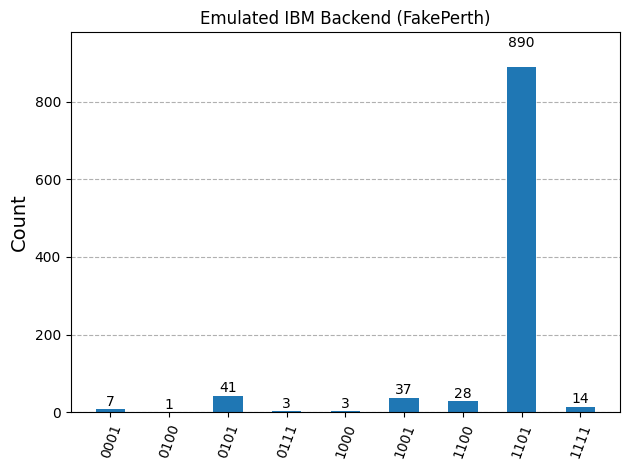

In [ ]:
from qiskit_ibm_runtime.fake_provider import FakePerth
from qiskit import transpile
from qiskit.visualization import plot_histogram

backend = FakePerth()
job = backend.run(transpile(qc, backend))
result = job.result()
counts_fake = result.get_counts()

plot_histogram(counts_fake, title="Emulated IBM Backend (FakePerth)")





### 🧠 Bernstein–Vazirani Algorithm Overview

- *Goal:* Find a hidden bit string s using a single query to the oracle.
- *Oracle Function:*  
  \( f(x) = s \cdot x \oplus b \)
  where  
  - s · x is the bitwise dot product mod 2  
  - b is an optional constant bit.

*Steps:*
1. Initialize n input qubits and one ancilla.
2. Apply X to the ancilla → creates |1⟩.
3. Apply Hadamard (H) to all qubits.
4. Call the oracle.
5. Apply Hadamard to inputs again.
6. Measure the input qubits — result reveals s.

🧩 If b=1, only the *ancilla’s phase* changes, not the measured bitstring.